# 2D Ising Model
2D Ising model using the metropolis-based Monte Carlo method, as described in Fig. 8.8 Schroeder (an undergraduate statistical mechanics/thermodynamics textbook). The magnetization M, the average energy U, the heat capacity C, and the magnetic susceptibility χ are all plotted as functions of temperature. The signature discontinuity in C and χ mark the critical temperature and phase transition of the 2D spin lattice.

In [1]:
import matplotlib.pyplot as plt

from numba import jit
import numpy as np

import random
import time

In [2]:
# Helper functions

# Calculate the energy of the lattice.
# The energy is the sum of interactions between spins divided by the total number of spins
@jit(nopython=True)
def calcE(s):
    E = 0
    for i in range(width):
        for j in range(width):
            E += -deltaU(s,i,j)/2
    return E/width**2

# Calculate magnetization. 
# Magnetization is the sum of all spins divided by the total number of spins
@jit(nopython=True)
def calcM(s):
    m = np.abs(s.sum())
    return m/width**2

# Calculate interaction energy between spins. Assume periodic boundaries
# Interaction energy will be the difference in energy due to flipping spin i,j 
# (i.e. 2*spin_value*neighboring_spins)
@jit(nopython=True)
def deltaU(s,i,j):
    #top
    if i == 0:
        t = s[width-1,j]  # periodic boundary
    else:
        t = s[i-1,j]
    #bottom
    if i == width-1:
        b = s[0,j]  # periodic boundary
    else:
        b = s[i+1,j]
    #left
    if j == 0:
        l = s[i,width-1]  # periodic boundary
    else:
        l = s[i,j-1]
    #right
    if j == width-1:
        r = s[i,0]  # periodic boundary
    else:
        r = s[i,j+1]
    return 2*s[i,j]*(t+b+r+l)  # difference in energy is i,j is flipped

# Monte carlo cycle
@jit(nopython=True)
def montecc(s,Temp,cycles):
    for m in range(cycles):
        i = random.randrange(width)  # choose random row
        j = random.randrange(width)  # choose random column
        ediff = deltaU(s,i,j)
        if ediff <= 0:
            s[i,j] = -s[i,j]  # flip spin
        elif random.random() < np.exp(-ediff/Temp):
            s[i,j] = -s[i,j]
    return s

# Compute physical quantities
@jit(nopython=True)
def computePQ(s,T,cycles):
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for p in range(cycles):
        s = montecc(s,T,1)
        E = calcE(s)
        M = calcM(s)
        En += E
        Mg += M
        En_sq += E*E
        Mg_sq += M*M
    aveEn = En/cycles
    mag = Mg/cycles
    sus = (Mg_sq/cycles-(Mg/cycles)**2)/T
    heatCap = (En_sq/cycles-(En/cycles)**2)/(T**2)
    return aveEn, mag, sus, heatCap

In [8]:
# Initial parameters

width = 32  # width of sqaure spin lattice; 64 points may take hours
s = np.random.choice([1,-1],size=(width,width))  # initial spin sites randomly (+1 or -1)
cycles = 1000 * width**2

# Initlaize temperature range (crosses critical temperature)
temps = np.arange(1.50,3.25,0.02)

# Inititalize magnetization, average energy, heat capacity, and susceptibility
mag = np.zeros(len(temps))
aveEn = np.zeros(len(temps))
heatCap = np.zeros(len(temps))
sus = np.zeros(len(temps))

start = time.time()
# Simulate at particular temperatures (temps) and compute physical quantities (magnetization, etc.)
for ind, T in enumerate(temps):
    # Cycle spins
    s = montecc(s,T,cycles)
    # Compute physical quanitites with 1000 cycles per spin at temperature T
    aveEn[ind], mag[ind], sus[ind], heatCap[ind] = computePQ(s,T,cycles)
    # Print completion status
    if ind % 20 == 0:
        print('precent complete:', '%.2f'%(ind/len(temps)*100),'%')
end = time.time()
print("Elapsed = %s" % (end - start))

precent complete: 0.00 %
precent complete: 22.73 %
precent complete: 45.45 %
precent complete: 68.18 %
precent complete: 90.91 %
Elapsed = 59.77536678314209


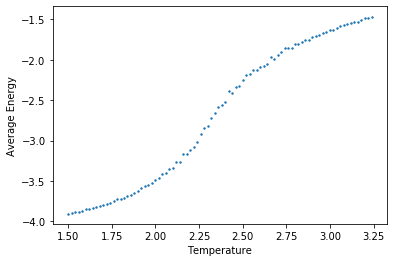

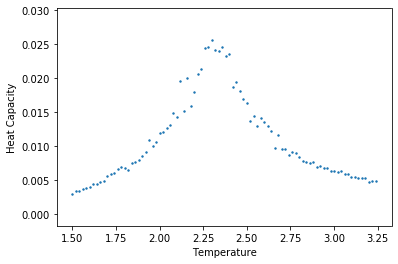

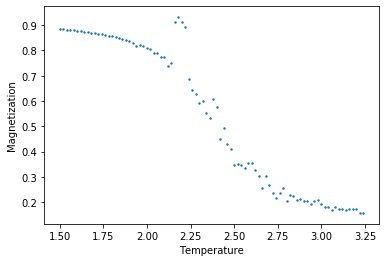

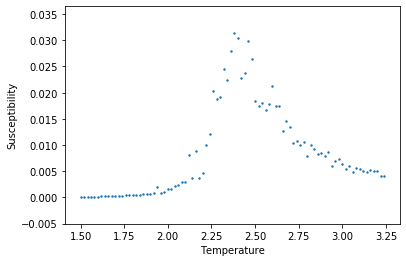

In [9]:
# Plot calculated quantities

plt.scatter(temps,aveEn,s=2)
plt.xlabel('Temperature')
plt.ylabel('Average Energy')
plt.show()

plt.scatter(temps,heatCap,s=2)
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity')
plt.show()

plt.scatter(temps,mag,s=2)
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

plt.scatter(temps,sus,s=2)
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.show()